In [128]:
import credentials as cr
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pickle
import statistics
import math
import datetime
import boto3

import warnings
warnings.filterwarnings('ignore')

### 1. Extract: die Daten aus einer mySQL Datenbank extrahieren

Unter dem Schema (=Datenbank) itsm liegen zwei Tabellen. Eine beinhaltet die Ticket-Daten, die andere dazugehörige Zeitinformationen. Ihr müsst beide über den Schlüssel "Incident_ID" joinen. Ihr könnt den Join beim initialen Extract machen (als SQL Code) oder in reinem Python mit Pandas.

1.1 Join with SQL Code

In [66]:
def join_SQL():
    print("Start Connection to RDS Database . . .")
    
    mydb = mysql.connector.connect(**cr.config) 

    print("Connection established: ", mydb)

    print("Start SQL query . . . ")

    mycursor = mydb.cursor(dictionary = True) 

    query = "SELECT * FROM itsm.ticket_data inner join itsm.ticket_time USING(Incident_ID) LIMIT 1;"

    mycursor.execute(query)

    myresult = mycursor.fetchall()

    df = pd.DataFrame(myresult)
    
    return df 

In [67]:
df = join_SQL()
df

Start Connection to RDS Database . . .
Connection established:  <mysql.connector.connection_cext.CMySQLConnection object at 0x7ff3786ed610>
Start SQL query . . . 


,Incident_ID,CI_Name,CI_CAT,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,...,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,IM0000004,SUB000508,subapplication,Web Based Application,WBS000162,Closed,4,4,4.0,0.601292279,...,None,2013-04-11 13:50:00,2013-04-11 13:51:00,"3,87,16,91,111",Other,1,SD0000007,2,999,999


#### 1.2. Join(merge) with Pandas

In [68]:
def pandas_read_sql (query):
    print("Start Connection to RDS Database . . .")
    
    mydb = mysql.connector.connect(**cr.config) 

    print("Connection established: ", mydb)

    mycursor = mydb.cursor() 

    query = query

    print(f"Start SQL query {query}")

    mycursor.execute(query)

    mycursor.fetchall()

    df = pd.read_sql(query, mydb)

    return df

In [69]:
# reading ticket_data table 
query = "SELECT * FROM itsm.ticket_data;"
df_ticket_data = pandas_read_sql(query)

Start Connection to RDS Database . . .
Connection established:  <mysql.connector.connection_cext.CMySQLConnection object at 0x7ff37a086040>
Start SQL query SELECT * FROM itsm.ticket_data;


In [70]:
df_ticket_data.head()

,CI_Name,CI_CAT,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_status,No_of_Reassignments
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4.0,0.601292279,incident,KM0000553,closed,26.0
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3.0,0.415049969,incident,KM0000611,closed,33.0
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,,0.517551335,request for information,KM0000339,closed,3.0
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4.0,0.642927218,incident,KM0000611,closed,13.0
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4.0,0.345258343,incident,KM0000611,closed,2.0


In [71]:
df_ticket_data.shape

(46606, 14)

In [72]:
# reading ticket_time table 
query = "SELECT * FROM itsm.ticket_time;"
df_ticket_time = pandas_read_sql(query)

Start Connection to RDS Database . . .
Connection established:  <mysql.connector.connection_cext.CMySQLConnection object at 0x7ff37ba404f0>
Start SQL query SELECT * FROM itsm.ticket_time;


In [73]:
df_ticket_time.head()

,Incident_ID,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,IM0000004,2012-05-02 13:32:00,NaT,2013-04-11 13:50:00,2013-04-11 13:51:00,"3,87,16,91,111",Other,1,SD0000007,2,999,999
1,IM0000005,2012-12-03 15:44:00,2013-02-12 12:31:00,2013-02-12 12:36:00,2013-02-12 12:36:00,"4,35,47,86,389",Software,1,SD0000011,1,999,999
2,IM0000006,2012-03-29 12:36:00,NaT,2014-01-13 15:12:00,2014-01-13 15:13:00,"4,84,31,19,444",No error - works as designed,1,SD0000017,999,999,999
3,IM0000011,2012-07-17 11:49:00,NaT,2013-11-14 09:31:00,2013-11-14 09:31:00,"4,32,18,33,333",Operator error,1,SD0000025,999,999,999
4,IM0000012,2012-10-08 11:01:00,NaT,2013-08-11 13:55:00,2013-08-11 13:55:00,"3,38,39,03,333",Other,1,SD0000029,999,999,999


In [74]:
df_ticket_time.shape

(46606, 12)

In [75]:
# joining the tables 
df_pd_merge = pd.merge(left = df_ticket_data, right = df_ticket_time, how = 'inner', on = 'Incident_ID' )

In [76]:
df_pd_merge.head()

,CI_Name,CI_CAT,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,...,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4.0,0.601292279,...,NaT,2013-04-11 13:50:00,2013-04-11 13:51:00,"3,87,16,91,111",Other,1,SD0000007,2,999,999
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3.0,0.415049969,...,2013-02-12 12:31:00,2013-02-12 12:36:00,2013-02-12 12:36:00,"4,35,47,86,389",Software,1,SD0000011,1,999,999
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,,0.517551335,...,NaT,2014-01-13 15:12:00,2014-01-13 15:13:00,"4,84,31,19,444",No error - works as designed,1,SD0000017,999,999,999
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4.0,0.642927218,...,NaT,2013-11-14 09:31:00,2013-11-14 09:31:00,"4,32,18,33,333",Operator error,1,SD0000025,999,999,999
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4.0,0.345258343,...,NaT,2013-08-11 13:55:00,2013-08-11 13:55:00,"3,38,39,03,333",Other,1,SD0000029,999,999,999


In [77]:
df_pd_merge.shape

(46606, 25)

### 2. Analysis / Visualization

In [78]:
# Looking for missing data
df_pd_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46606 entries, 0 to 46605
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   CI_Name                     46606 non-null  object        
 1   CI_CAT                      46606 non-null  object        
 2   CI_Subcat                   46606 non-null  object        
 3   WBS                         46606 non-null  object        
 4   Incident_ID                 46606 non-null  object        
 5   Status                      46606 non-null  object        
 6   Impact                      46606 non-null  object        
 7   Urgency                     46606 non-null  object        
 8   Priority                    46606 non-null  object        
 9   number_cnt                  46606 non-null  object        
 10  Category                    46606 non-null  object        
 11  KB_number                   46606 non-null  object    

In [79]:
df_pd_merge.dtypes

CI_Name                               object
CI_CAT                                object
CI_Subcat                             object
WBS                                   object
Incident_ID                           object
Status                                object
Impact                                object
Urgency                               object
Priority                              object
number_cnt                            object
Category                              object
KB_number                             object
Alert_status                          object
No_of_Reassignments                   object
Open_Time                     datetime64[ns]
Reopen_Time                   datetime64[ns]
Resolved_Time                 datetime64[ns]
Close_Time                    datetime64[ns]
Handle_Time_hrs                       object
Closure_Code                          object
No_of_Related_Interactions             int64
Related_Interaction                   object
No_of_Rela

In [80]:
# unique values of CI_Subcat data category
df_pd_merge['CI_Subcat'].unique()

array(['Web Based Application', 'Desktop Application',
       'Server Based Application', 'SAP', 'Client Based Application',
       'Citrix', 'Standard Application', 'Windows Server', 'Laptop',
       'Linux Server', '', 'Monitor', 'Automation Software', 'SAN',
       'Banking Device', 'Desktop', 'Database', 'Oracle Server',
       'Keyboard', 'Printer', 'Exchange', 'System Software', 'VDI',
       'Encryption', 'Omgeving', 'MigratieDummy', 'Scanner', 'Controller',
       'DataCenterEquipment', 'KVM Switches', 'Switch',
       'Database Software', 'Network Component', 'Unix Server', 'Lines',
       'ESX Cluster', 'zOS Server', 'SharePoint Farm', 'NonStop Server',
       'Application Server', 'Security Software', 'Thin Client',
       'zOS Cluster', 'Router', 'VMWare', 'Net Device', 'Neoview Server',
       'MQ Queue Manager', 'UPS', 'Number', 'Iptelephony',
       'Windows Server in extern beheer', 'Modem', 'X86 Server',
       'ESX Server', 'Virtual Tape Server', 'IPtelephony',
      

In [81]:
# number of unique values of CI_Subcat data category
df_pd_merge['CI_Subcat'].nunique()

65

Text(0.5, 1.0, 'Histogram of resolved tickets')

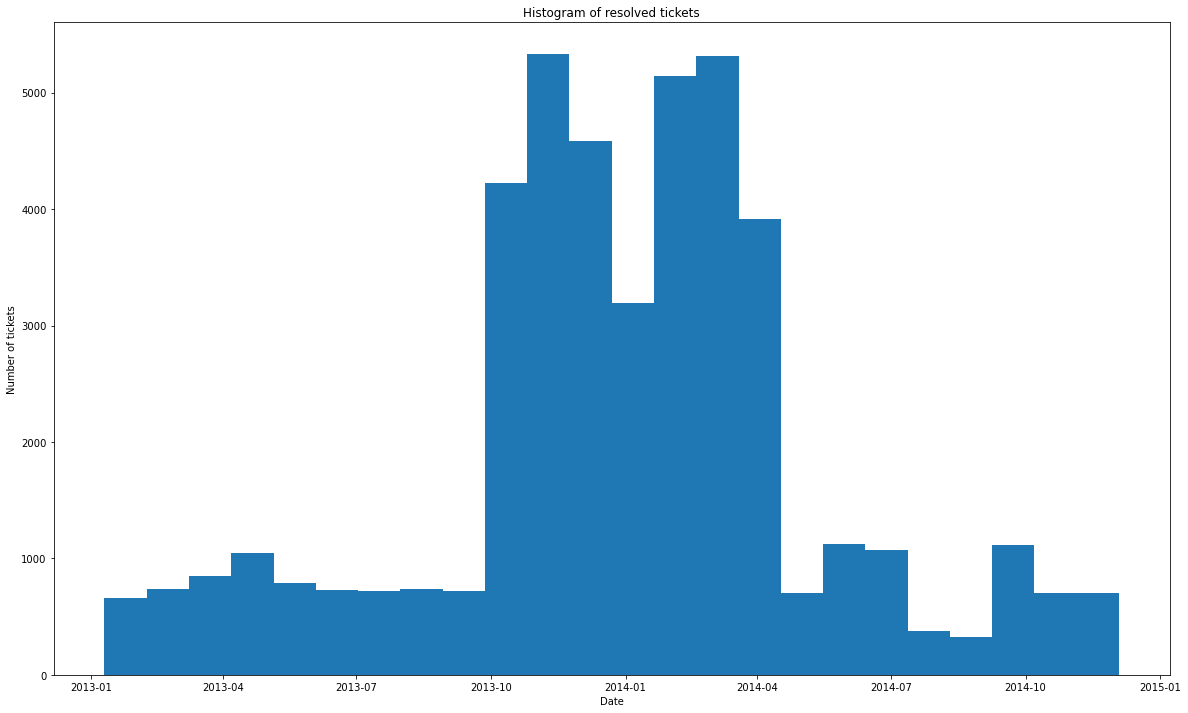

In [82]:
# histogram of Resolved_time data category visualized with matplotlib 
plt.rcParams["figure.figsize"] = (20,12)
plt.hist(df_pd_merge['Resolved_Time'], bins=24)
plt.xlabel('Date')
plt.ylabel('Number of tickets')
plt.title('Histogram of resolved tickets')

Text(0.5, 1.0, 'Histogram of CI_Subcat')

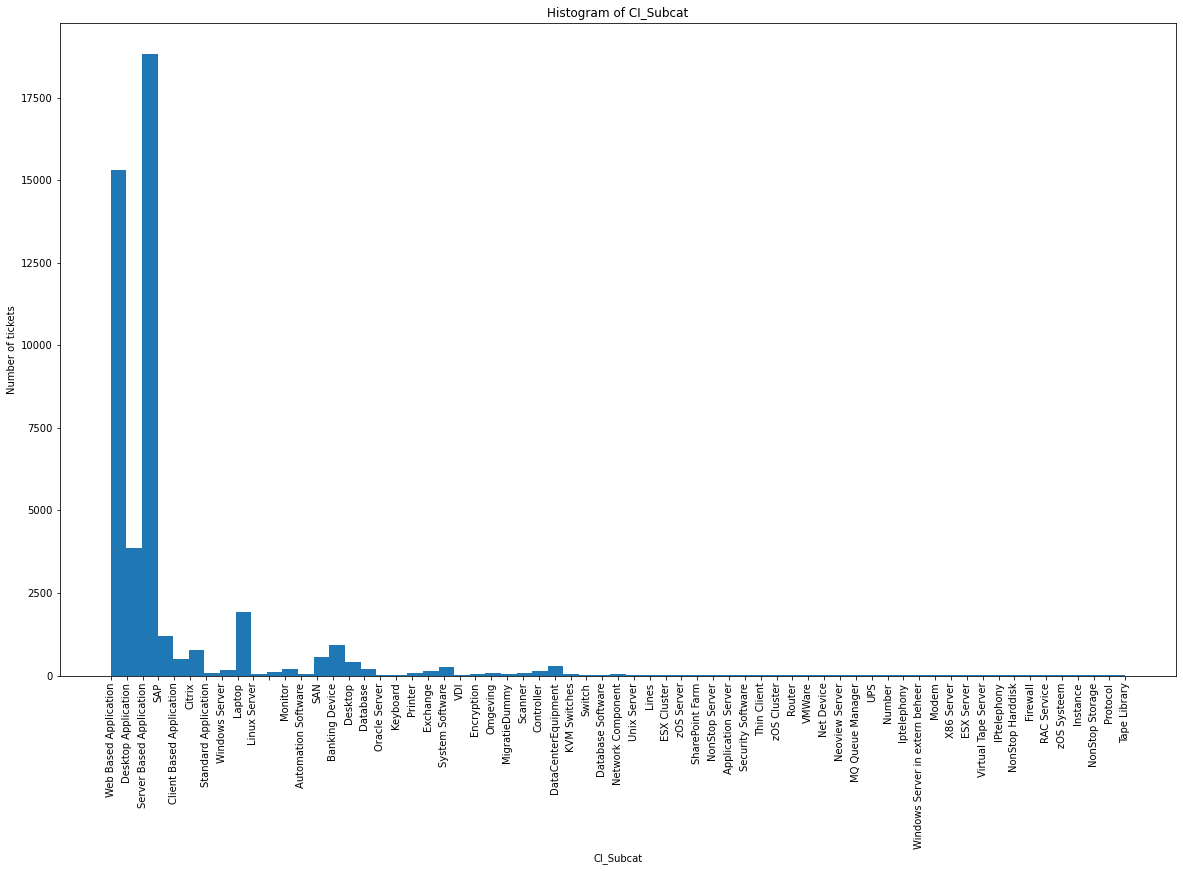

In [83]:
# histogram of CI_Subcat data category visualized with matplotlib 
plt.rcParams["figure.figsize"] = (20,12)
plt.hist(df_pd_merge['CI_Subcat'], bins=df_pd_merge['CI_Subcat'].nunique())
plt.xticks(rotation='vertical')
plt.xlabel('CI_Subcat')
plt.ylabel('Number of tickets')
plt.title('Histogram of CI_Subcat')

In [84]:
# histogram of CI_Subcat data category visualized with plotly 
fig = px.histogram(df_pd_merge, x="CI_Subcat", title='Histogram of CI_Subcat', width=1200, height=600)
fig.update_layout(yaxis_title="Number of Tickets")
fig.show()

In [85]:
# sorted by count, tick angle turned with 45 degree
fig = px.histogram(df_pd_merge, x="CI_Subcat", title='Histogram of CI_Subcat', width=1200, height=600)
fig.update_layout(yaxis_title="Number of Tickets")
fig.update_xaxes(categoryorder='total descending')
fig.update_xaxes(tickangle=45)
fig.show()

### 3. Transform - A) ML-Vorhersagen

#### 3.1 Einfach: Dummy-Daten erzeugen, eine extra Pandas-Spalte erzeugen und dort Zufallszahlen (von 1 bis 10) reinschreiben und diese "Predictions" nennen.

In [86]:
def dummy_predictions():
    random_list = []
    for i in range(df_pd_merge.shape[0]):
        random_number = np.random.randint(1, 10)
        random_list.append(random_number)
    df_pd_merge['Predictions_dummy'] = random_list

In [87]:
dummy_predictions()

In [88]:
df_pd_merge['Predictions_dummy'].head()

0    7
1    6
2    7
3    4
4    9
Name: Predictions_dummy, dtype: int64

### 3.2 Mittel:
1. gespeichertes ML-Modell (finalized_model.sav) mit der Bibliothek Pickle reinladen und mit
den Daten eine Vorhersage der Priorität ausführen. 
2. 4 numerische Spalte auswaehlen und als Input eingeben: pruefen ob alle Werte wirklich numerisch sind, ihr müsst sonst eine Bereinigung der Daten machen. 
3. Die Vorhersage an den extrahierten SQL Datensatz anfügen.

##### 3.2.1. gespeichertes ML-Modell (finalized_model.sav) mit der Bibliothek Pickle reinladen und mit

In [89]:
# https://scikit-learn.org/stable/model_persistence.html 
loaded_model = pickle.load(open('finalized_model.sav', 'rb'))

In [90]:
loaded_model

SVC(C=10, gamma=0.1)

#### 3.2.2. 4 numerische Spalte auswaehlen pruefen ob alle Werte wirklich numerisch sind

In [91]:
# which columns are integers?
# int_columns = df.select_dtypes(include='int').columns

In [131]:
df_numeric_columns =  df_pd_merge[['Impact', 'Urgency', 'No_of_Related_Interactions', 'number_cnt']]
df_numeric_columns

,Impact,Urgency,No_of_Related_Interactions,number_cnt
0,4,4,1,0.601292279
1,3,3,1,0.415049969
2,NS,3,1,0.517551335
3,4,4,1,0.642927218
4,4,4,1,0.345258343
...,...,...,...,...
46601,4,4,1,0.23189604
46602,4,4,1,0.805153085
46603,5,5,1,0.917466294
46604,4,4,1,0.701278158


In [93]:
# If errors=‘coerce’, then invalid parsing will be set as NaN.
def convert_numeric(list_columns):
    df = pd.DataFrame(columns=list_columns)
    for column_name in list_columns:
        numeric_column = pd.to_numeric(df_pd_merge[column_name], errors='coerce')
        df[column_name] = pd.DataFrame(numeric_column)
    df.fillna(0, inplace=True)
    return df

In [94]:
list_columns = ['Impact', 'Urgency', 'No_of_Related_Interactions', 'number_cnt']
df_numeric_columns = convert_numeric(list_columns)
df_numeric_columns

,Impact,Urgency,No_of_Related_Interactions,number_cnt
0,4.0,4.0,1,0.601292
1,3.0,3.0,1,0.415050
2,0.0,3.0,1,0.517551
3,4.0,4.0,1,0.642927
4,4.0,4.0,1,0.345258
...,...,...,...,...
46601,4.0,4.0,1,0.231896
46602,4.0,4.0,1,0.805153
46603,5.0,5.0,1,0.917466
46604,4.0,4.0,1,0.701278


#### 3.2.3. Die Vorhersage an den extrahierten SQL Datensatz anfügen.

In [95]:
predictions = loaded_model.predict(df_numeric_columns)

In [96]:
df_pd_merge['Predictions_model'] = predictions

In [97]:
df_pd_merge['Predictions_model'].head(5)

0    4.0
1    4.0
2    5.0
3    4.0
4    4.0
Name: Predictions_model, dtype: float64

### 3.3. Schwerer:
1. Selber ein ML-Modell extrahieren, 
2. die Daten analog zum Kaggle Artikel aufbereiten (feature enginnering, one hot encoding etc.) und dem ML Modell als Input geben.
3. Der Output (also die Vorhersage der Priorität) wieder als extra Spalte in den Pandas Dataframe hinzufügen

### 4. Transform  - B) Datentransformationen

![Screenshot.png](attachment:Screenshot.png) 

#### 4.1 Filter first 3 characters

In [98]:
# https://www.datasciencemadesimple.com/return-first-n-character-from-left-of-column-in-pandas-python/
df_transform = df_pd_merge.copy()

In [99]:
df_transform['CI_Name'].head()

0    SUB000508
1    WBA000124
2    DTA000024
3    WBA000124
4    WBA000124
Name: CI_Name, dtype: object

In [100]:
df_transform['CI_Name'] = df_transform['CI_Name'].str[:3]

In [101]:
df_transform['CI_Name'].head()

0    SUB
1    WBA
2    DTA
3    WBA
4    WBA
Name: CI_Name, dtype: object

#### 4.2. Leave only last 2 digits 

In [102]:
df_transform['WBS'] = df_transform['WBS'].str[-2:]

In [103]:
df_transform['WBS'].head()

0    62
1    88
2    92
3    88
4    88
Name: WBS, dtype: object

#### 4.3. Calculate the average, round down 

In [104]:
df_transform['Handle_Time_hrs'].loc[1]

'4,35,47,86,389'

In [105]:
list = df_transform['Handle_Time_hrs'].loc[46605].split(',')
list[0]
list = ['.'.join(list)]
list
# list_int = [float(x) for x in list] 
# mean = math.floor(statistics.mean(list_int))
# mean

['0.586388889']

In [106]:
def floor_mean():
    list_mean = []
    for index, row in df_transform.iterrows():
        list = df_transform['Handle_Time_hrs'].loc[index].split(',')
        if list[0] == '0':
            list = ['.'.join(list)] # or list = [1]
        else:
            pass
        list_int = [float(x) for x in list] # or [int(x) for x in list]
        mean = math.floor(statistics.mean(list_int))
        list_mean.append(mean)
    df_transform['Handle_Time_hrs_avg'] = list_mean

In [107]:
floor_mean()

In [108]:
df_transform['Handle_Time_hrs_avg'].head()
# df_transform['Handle_Time_hrs_avg'].tail()

0     61
1    112
2    116
3     84
4     83
Name: Handle_Time_hrs_avg, dtype: int64

#### 4.4. Remove "–" and ":" and change order 

In [109]:
df_transform['Close_Time'].head()

0   2013-04-11 13:51:00
1   2013-02-12 12:36:00
2   2014-01-13 15:13:00
3   2013-11-14 09:31:00
4   2013-08-11 13:55:00
Name: Close_Time, dtype: datetime64[ns]

In [110]:
datetime = df_transform['Close_Time'].loc[0]
datetime.strftime('%d%m%Y%H%M%S')

'11042013135100'

In [111]:
def convert_datetime():
    list_strftime = []
    for index, row in df_transform.iterrows():
        datetime = df_transform['Close_Time'].loc[index] 
        strftime = datetime.strftime('%d%m%Y%H%M%S')
        list_strftime.append(strftime)
    df_transform['Close_Time_strftime'] = list_strftime

In [112]:
convert_datetime()

In [113]:
df_transform['Close_Time_strftime'].head()

0    11042013135100
1    12022013123600
2    13012014151300
3    14112013093100
4    11082013135500
Name: Close_Time_strftime, dtype: object

#### 4.5. Add 5 leading zeroes to integer value 

In [114]:
df_transform['No_of_Reassignments'].head()

0    26.0
1    33.0
2     3.0
3    13.0
4     2.0
Name: No_of_Reassignments, dtype: object

In [115]:
def adding_zeros():
    list = []
    zeros = '00000'
    for index, row in df_transform.iterrows():
        reassignments = df_transform['No_of_Reassignments'].loc[index]
        concat_nr = zeros + reassignments
        concat_nr = concat_nr.split('.')[0]
        list.append(concat_nr) 
    df_transform['No_of_Reassignments_zeros'] = list

In [116]:
adding_zeros()

In [117]:
df_transform['No_of_Reassignments_zeros'].head()

0    0000026
1    0000033
2     000003
3    0000013
4     000002
Name: No_of_Reassignments_zeros, dtype: object

#### 4.6. Add column "SLA_Violation"

IF No_of_Reassignments > 25
AND Priority > 2
Return "yes"
Else "no"

In [118]:
# converting columns to numeric 
list_columns = ['No_of_Reassignments','Priority']
df_numeric_columns = convert_numeric(list_columns)
df_numeric_columns

,No_of_Reassignments,Priority
0,26.0,4.0
1,33.0,3.0
2,3.0,0.0
3,13.0,4.0
4,2.0,4.0
...,...,...
46601,0.0,4.0
46602,0.0,4.0
46603,0.0,5.0
46604,0.0,4.0


In [119]:
def add_sla_violation():
    sla_violation = []
    for index, row in df_numeric_columns.iterrows():
        if df_numeric_columns['No_of_Reassignments'].loc[index] > 25 and df_numeric_columns['Priority'].loc[index] > 2:
            sla_violation.append('Yes')
        else:
            sla_violation.append('No')    
    df_transform['SLA_Violation'] = sla_violation

In [120]:
add_sla_violation()

In [121]:
df_transform['SLA_Violation'].head()

0    Yes
1    Yes
2     No
3     No
4     No
Name: SLA_Violation, dtype: object

In [122]:
df_transform.head()

,CI_Name,CI_CAT,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,...,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change,Predictions_dummy,Predictions_model,Handle_Time_hrs_avg,Close_Time_strftime,No_of_Reassignments_zeros,SLA_Violation
0,SUB,subapplication,Web Based Application,62,IM0000004,Closed,4,4,4.0,0.601292279,...,SD0000007,2,999,999,7,4.0,61,11042013135100,0000026,Yes
1,WBA,application,Web Based Application,88,IM0000005,Closed,3,3,3.0,0.415049969,...,SD0000011,1,999,999,6,4.0,112,12022013123600,0000033,Yes
2,DTA,application,Desktop Application,92,IM0000006,Closed,NS,3,,0.517551335,...,SD0000017,999,999,999,7,5.0,116,13012014151300,000003,No
3,WBA,application,Web Based Application,88,IM0000011,Closed,4,4,4.0,0.642927218,...,SD0000025,999,999,999,4,4.0,84,14112013093100,0000013,No
4,WBA,application,Web Based Application,88,IM0000012,Closed,4,4,4.0,0.345258343,...,SD0000029,999,999,999,9,4.0,83,11082013135500,000002,No


### 5. Load 
1. Wandelt nun eure Pandas-Daten in CSV-Daten um
2. legt diese im S3 Bucket mit dem Namen module1etl ab, nutzt wieder euren Namen als Path-Prefix.

#### 5.1 Pandas Dataframe to .csv

In [125]:
df_transform.to_csv('data_transformation.csv', index=False)

In [127]:
#df = pd.read_csv('data_transformation.csv')
#df

#### 5.2. S3 Upload

In [130]:
# S3.meta.client.upload_file('filename', 'bucket', 'key')
s3 = boto3.resource('s3')
s3.meta.client.upload_file('data_transformation.csv', 'module1etl', 'attila/data_transformation.csv')